# Journey through *Titanic: Machine Learning from Disaster*

### My first Kaggle Kernel

Yes, like most of you guys I got started practicing data science with the Titanic competition. I learned a lot and realized that there is much to learn, and that's exciting! As these were my first experiences with Kaggle I would like to share them with you on my first Kaggle Kernel.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
import numpy as np
import re

In [2]:
df = pd.DataFrame(pd.read_csv('../input/titanic/train.csv'))
df_test = pd.DataFrame(pd.read_csv('../input/titanic/test.csv'))

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First we should do some initial exploratory data analysis:

/opt/conda/lib/python3.6/site-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


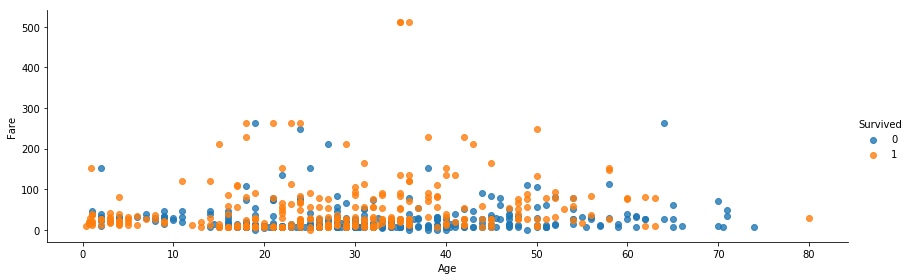

In [4]:
sns.lmplot(data = df, x = 'Age', y = 'Fare', hue = 'Survived', fit_reg = False, size = 4, aspect = 3)
plt.show()

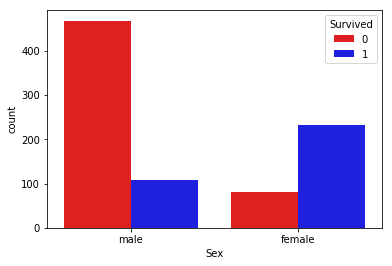

In [5]:
def countplot(var):
    sns.countplot(data = df, x = var, hue = 'Survived', palette = ('R', 'b'))
    plt.show()
countplot('Sex')

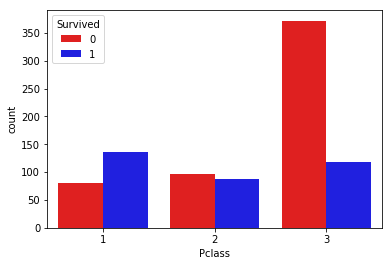

In [6]:
countplot('Pclass')

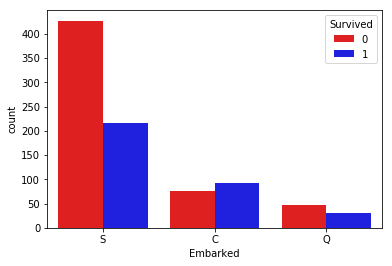

In [7]:
countplot('Embarked')

Okay, we can observe some things:

* the age-fare plot shows a distributed result, but some differences are evident on the extreme values.
* being a man from 3rd class that embarked on 'S' may not be very good. 
* most of the passengers were men from 3rd class that embarked on 'S'.

Now, let's take a look at the missing values and what to do with them.

In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Missing Values

Let's handle the **Age** missing values first. We could just fill with -1 or with the mean, but I think we can be more careful. 

We will calculate the **Age** mean of each **Pclass** and **Sex** and fill the NaN values with them.

In [9]:
print(df.groupby(['Pclass']).mean()['Age'])
print('\n')
print(df.groupby(['Sex']).mean()['Age'])

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64


Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64


In [10]:
# fill NaN Age values with the means, separating by Sex and Pclass

def age_nan(df):
    for i in df.Sex.unique():
        for j in df.Pclass.unique():
            x = df.loc[((df.Sex == i) & (df.Pclass == j)), 'Age'].mean()
            df.loc[((df.Sex == i) & (df.Pclass == j)), 'Age'] = df.loc[((df.Sex == i) & (df.Pclass == j)), 'Age'].fillna(x)

age_nan(df)
age_nan(df_test)

There were just 2 NaN values on Embarked, so it's reasonable to fill them with Embarked's mode: **S**

In [11]:
# fill NaN values of Embarked with 'S', because it's the most commom value for it

df['Embarked'] = df['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

The **Cabin** feature has a significant number of NaN values, and my first thought was to drop the column. But we can extract some interesting info from this, from separating who had a specified Cabin and who didn't. So we created the **Cabin_NaN** feature, that returns 1 for NaN values. 

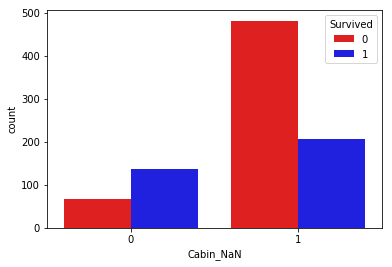

In [12]:
#creating Cabin_NaN to test and train dataset and analysing it

df['Cabin_NaN'] = df['Cabin'].isnull().astype(int)
df_test['Cabin_NaN'] = df_test['Cabin'].isnull().astype(int)
countplot('Cabin_NaN')

Now we should handle the test dataset missing values as well. We found only 1 NaN value for Fare, that was filled with -1.

In [13]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Cabin_NaN        0
dtype: int64

In [14]:
df_test.Fare = df_test.Fare.fillna(-1)

This function builds a Logistic Regression prediction model, make a cross validation and return the score. With it we can easily see, progressively, how the model improves as we create new features to feed the algorithm.

In [15]:
# logistic regression - cross validation function

def reg_cross_val(variables):
    
    X = df[variables]
    y = df['Survived']
    
    rkfold = RepeatedKFold(n_splits = 2, n_repeats = 10, random_state = 10)
    result = []
    for treino, teste in rkfold.split(X):
        X_train, X_test = X.iloc[treino], X.iloc[teste]
        y_train, y_test = y.iloc[treino], y.iloc[teste]
        
        reg = LogisticRegression(max_iter = 500)
        reg.fit(X_train, y_train)
        result.append(reg.score(X_test, y_test))
        
    return np.mean(result)

Logistic Regression must "be fed" with numbers, not strings. So a new feature **Sex_bin** was created based on **Sex** info. 0 for male and 1 for female.

In [16]:
#creating feature: Sex_bin

def is_female(x):
    if x == 'female':
        return 1
    else:
        return 0

df['Sex_bin'] = df['Sex'].map(is_female)
df_test['Sex_bin'] = df_test['Sex'].map(is_female)

Same thing with **Embarked**, but here we have 3 possible values, so features were created for S and C.

No, Q was not ignored. But it's logical that if someone didn't embark on S or C, surely did on Q.

In [17]:
# creating features: Embarked_S and Embarked_C

def embarked_s(x):
    if x == 'S':
        return 1
    else:
        return 0

df['Embarked_S'] = df['Embarked'].map(embarked_s)
df_test['Embarked_S'] = df_test['Embarked'].map(embarked_s)

def embarked_c(x):
    if x == 'C':
        return 1
    else:
        return 0
    
df['Embarked_C'] = df['Embarked'].map(embarked_c)
df_test['Embarked_C'] = df_test['Embarked'].map(embarked_c)

## First try (with and withouht the created features):

In [18]:
variables_before = ['Age', 'Pclass', 'Fare', 'SibSp', 'Parch']
print('Before the new features:', reg_cross_val(variables_before))

variables = ['Age', 'Sex_bin', 'Pclass', 'Fare', 'SibSp', 'Parch', 'Embarked_S',\
             'Embarked_C', 'Cabin_NaN']

print('With the new features:', reg_cross_val(variables))

Before the new features: 0.7006696226129894
With the new features: 0.8030228749937016


Nice! It also seems reasonable to merge **SibSp** and **Parch** features into 1: **Family**. But it's yet more reasonable if we visualy check that before doing anything, so let's make some late exploratory data analysis here:

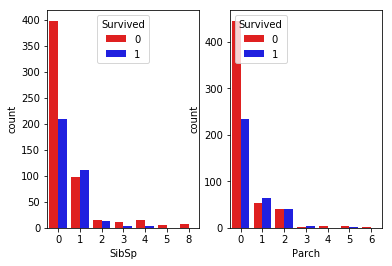

In [28]:
fig, ax =plt.subplots(1,2)
sns.countplot(data = df, x = 'SibSp', hue = 'Survived', palette = ('R', 'b'), ax = ax[0])
sns.countplot(data = df, x = 'Parch', hue = 'Survived', palette = ('R', 'b'), ax = ax[1])
plt.show()

In [30]:
# creating 'Family':

df['Family'] = df.SibSp + df.Parch
df_test['Family'] = df_test.SibSp + df_test.Parch

In [32]:
variables = ['Age', 'Sex_bin', 'Pclass', 'Fare', 'Embarked_S',\
             'Embarked_C', 'Cabin_NaN', 'Family']

reg_cross_val(variables)

0.8016755680959339

Ticket and Name features may have some interesting information as well. The most commom words or terms in them may give us some ideas.

In [19]:
text_ticket = ''
for i in df.Ticket:
    text_ticket += i
    
lista = re.findall('[a-zA-Z]+', text_ticket)
print('Most repeated terms in Tickets: \n')
print(pd.Series(lista).value_counts().head(10))

Most repeated terms in Tickets: 

C        63
PC       60
A        58
O        37
STON     18
SOTON    18
S        15
P        13
W        13
SC       13
dtype: int64


In [20]:
# creating features based on some commom words in Ticket feature

df['CA'] = df['Ticket'].str.contains('CA|C.A.').astype(int)
df['SOTON'] = df['Ticket'].str.contains('SOTON|STON').astype(int)
df['PC'] = df['Ticket'].str.contains('PC').astype(int)
df['SC'] = df['Ticket'].str.contains('SC|S.C').astype(int)
df['C'] = df['Ticket'].str.contains('C').astype(int)

# same with the df_test

df_test['CA'] = df_test['Ticket'].str.contains('CA|C.A.').astype(int)
df_test['SOTON'] = df_test['Ticket'].str.contains('SOTON|STON').astype(int)
df_test['PC'] = df_test['Ticket'].str.contains('PC').astype(int)
df_test['SC'] = df_test['Ticket'].str.contains('SC|S.C').astype(int)
df_test['C'] = df_test['Ticket'].str.contains('C').astype(int)

In [21]:
text_name = ''
for i in df.Name:
    text_name += i
    
lista = re.findall('[a-zA-Z]+', text_name)
print('Most repeated words in Name column: \n')
print(pd.Series(lista).value_counts().head(10))

Most repeated words in Name column: 

Mr         521
Miss       182
Mrs        129
William     49
Master      40
John        28
Henry       19
Charles     17
Thomas      17
George      16
dtype: int64


In [22]:
# creating features based on some commom words in Name feature

df['Master'] = df['Name'].str.contains('Master').astype(int)
df['Mr'] = df['Name'].str.contains('Mr').astype(int)
df['Miss'] = df['Name'].str.contains('Miss').astype(int)
df['Mrs'] = df['Name'].str.contains('Mrs').astype(int)

#same with df_teste

df_test['Master'] = df_test['Name'].str.contains('Master').astype(int)
df_test['Mr'] = df_test['Name'].str.contains('Mr').astype(int)
df_test['Miss'] = df_test['Name'].str.contains('Miss').astype(int)
df_test['Mrs'] = df_test['Name'].str.contains('Mrs').astype(int)

### Second try:

In [34]:
variables = ['Age', 'Sex_bin', 'Pclass', 'Fare', 'Embarked_S','Embarked_C',\
             'CA', 'SOTON', 'PC', 'SC','C', 'Mr', 'Miss', 'Master', 'Mrs', 'Family']

print(reg_cross_val(variables))

0.8249095581196151


Okay, we had a bit of a improvement on our validation here!

## Submiting

In [27]:
variables = ['Age', 'Sex_bin', 'Pclass', 'Fare','Family', 'Embarked_S','Embarked_C','Cabin_NaN',\
             'CA', 'SOTON', 'PC', 'SC', 'Master', 'Mr', 'Miss', 'C', 'Mrs']

X = df[variables]
y = df['Survived']

reg = LogisticRegression(max_iter = 500)
reg.fit(X,y)
resp = reg.predict(df_test[variables])

submit = pd.Series(resp, index=df_test['PassengerId'], name='Survived')
submit.to_csv("model.csv", header=True)

## Thanks for your attention!
Comments and feedbacks are most welcome :)